In [4]:
%pip install "zenml[server]"

!zenml integration install openai langchain -y
import IPython

# automatically restart kernel
IPython.Application.instance().kernel.do_shutdown(restart=True)

Note: you may need to restart the kernel to use updated packages.
Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
⠸ Installing integrations.....Requirement already satisfied: openai>=0.27.0 in /home/wjayesh/slackbot/lib/python3.9/site-packages (0.27.2)
⠼ Installing integrations...Requirement already satisfied: requests>=2.20 in /home/wjayesh/slackbot/lib/python3.9/site-packages (from openai>=0.27.0) (2.31.0)
⠴ Installing integrations...Requirement already satisfied: PyYAML>=5.3 in /home/wjayesh/slackbot/lib/python3.9/site-packages (from langchain>=0.0.116) (6.0.1)
⠦ Installing integrations...Requirement already satisfied: greenlet!=0.4.17 in /home/wjayesh/slackbot/lib/python3.9/site-packages (from SQLAlchemy<3,>=1.4->langchain>=0.0.116) (2.0.2)
⠧ Installing integrations...
Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
⠋ In

{'status': 'ok', 'restart': True}

: 

### 🍡 The case for an ML Pipeline

As an ML practitioner, you are probably familiar with building ML models using Scikit-learn, PyTorch, TensorFlow, or similar. An ML Pipeline is simply an extension, including other steps you would typically do before or after building a model, like data acquisition, preprocessing, model deployment, or monitoring. The ML pipeline essentially defines a step-by-step procedure of your work as an ML practitioner. Defining ML pipelines explicitly in code is great because:

- We can easily rerun all of our work, not just the model, eliminating bugs and making our models easier to reproduce.
- Data and models can be versioned and tracked, so we can see at a glance which dataset a model was trained on and how it compares to other models.
- If the entire pipeline is coded up, we can automate many operational tasks, like retraining and redeploying models when the underlying problem or data changes or rolling out new and improved models with CI/CD workflows.

Having a clearly defined ML pipeline is essential for ML teams that aim to serve models on a large scale.

### 🧘 ZenML Setup
Throughout this series, we will define our ML pipelines using ZenML. ZenML is an excellent tool for this task, as it is straightforward and intuitive to use and has integrations with most of the advanced MLOps tools we will want to use later. Make sure you have ZenML installed (via pip install zenml). Next, let's run some commands to make sure you start with a fresh ML stack.

In [ ]:
!rm -rf .zen
!zenml init

!zenml up
!zenml stack describe

### Let's go step-by-step

A ZenML pipeline is built up of several steps. Each step can be defined as a Python function which can either take in inputs from other steps, or directly from the pipeline or user.

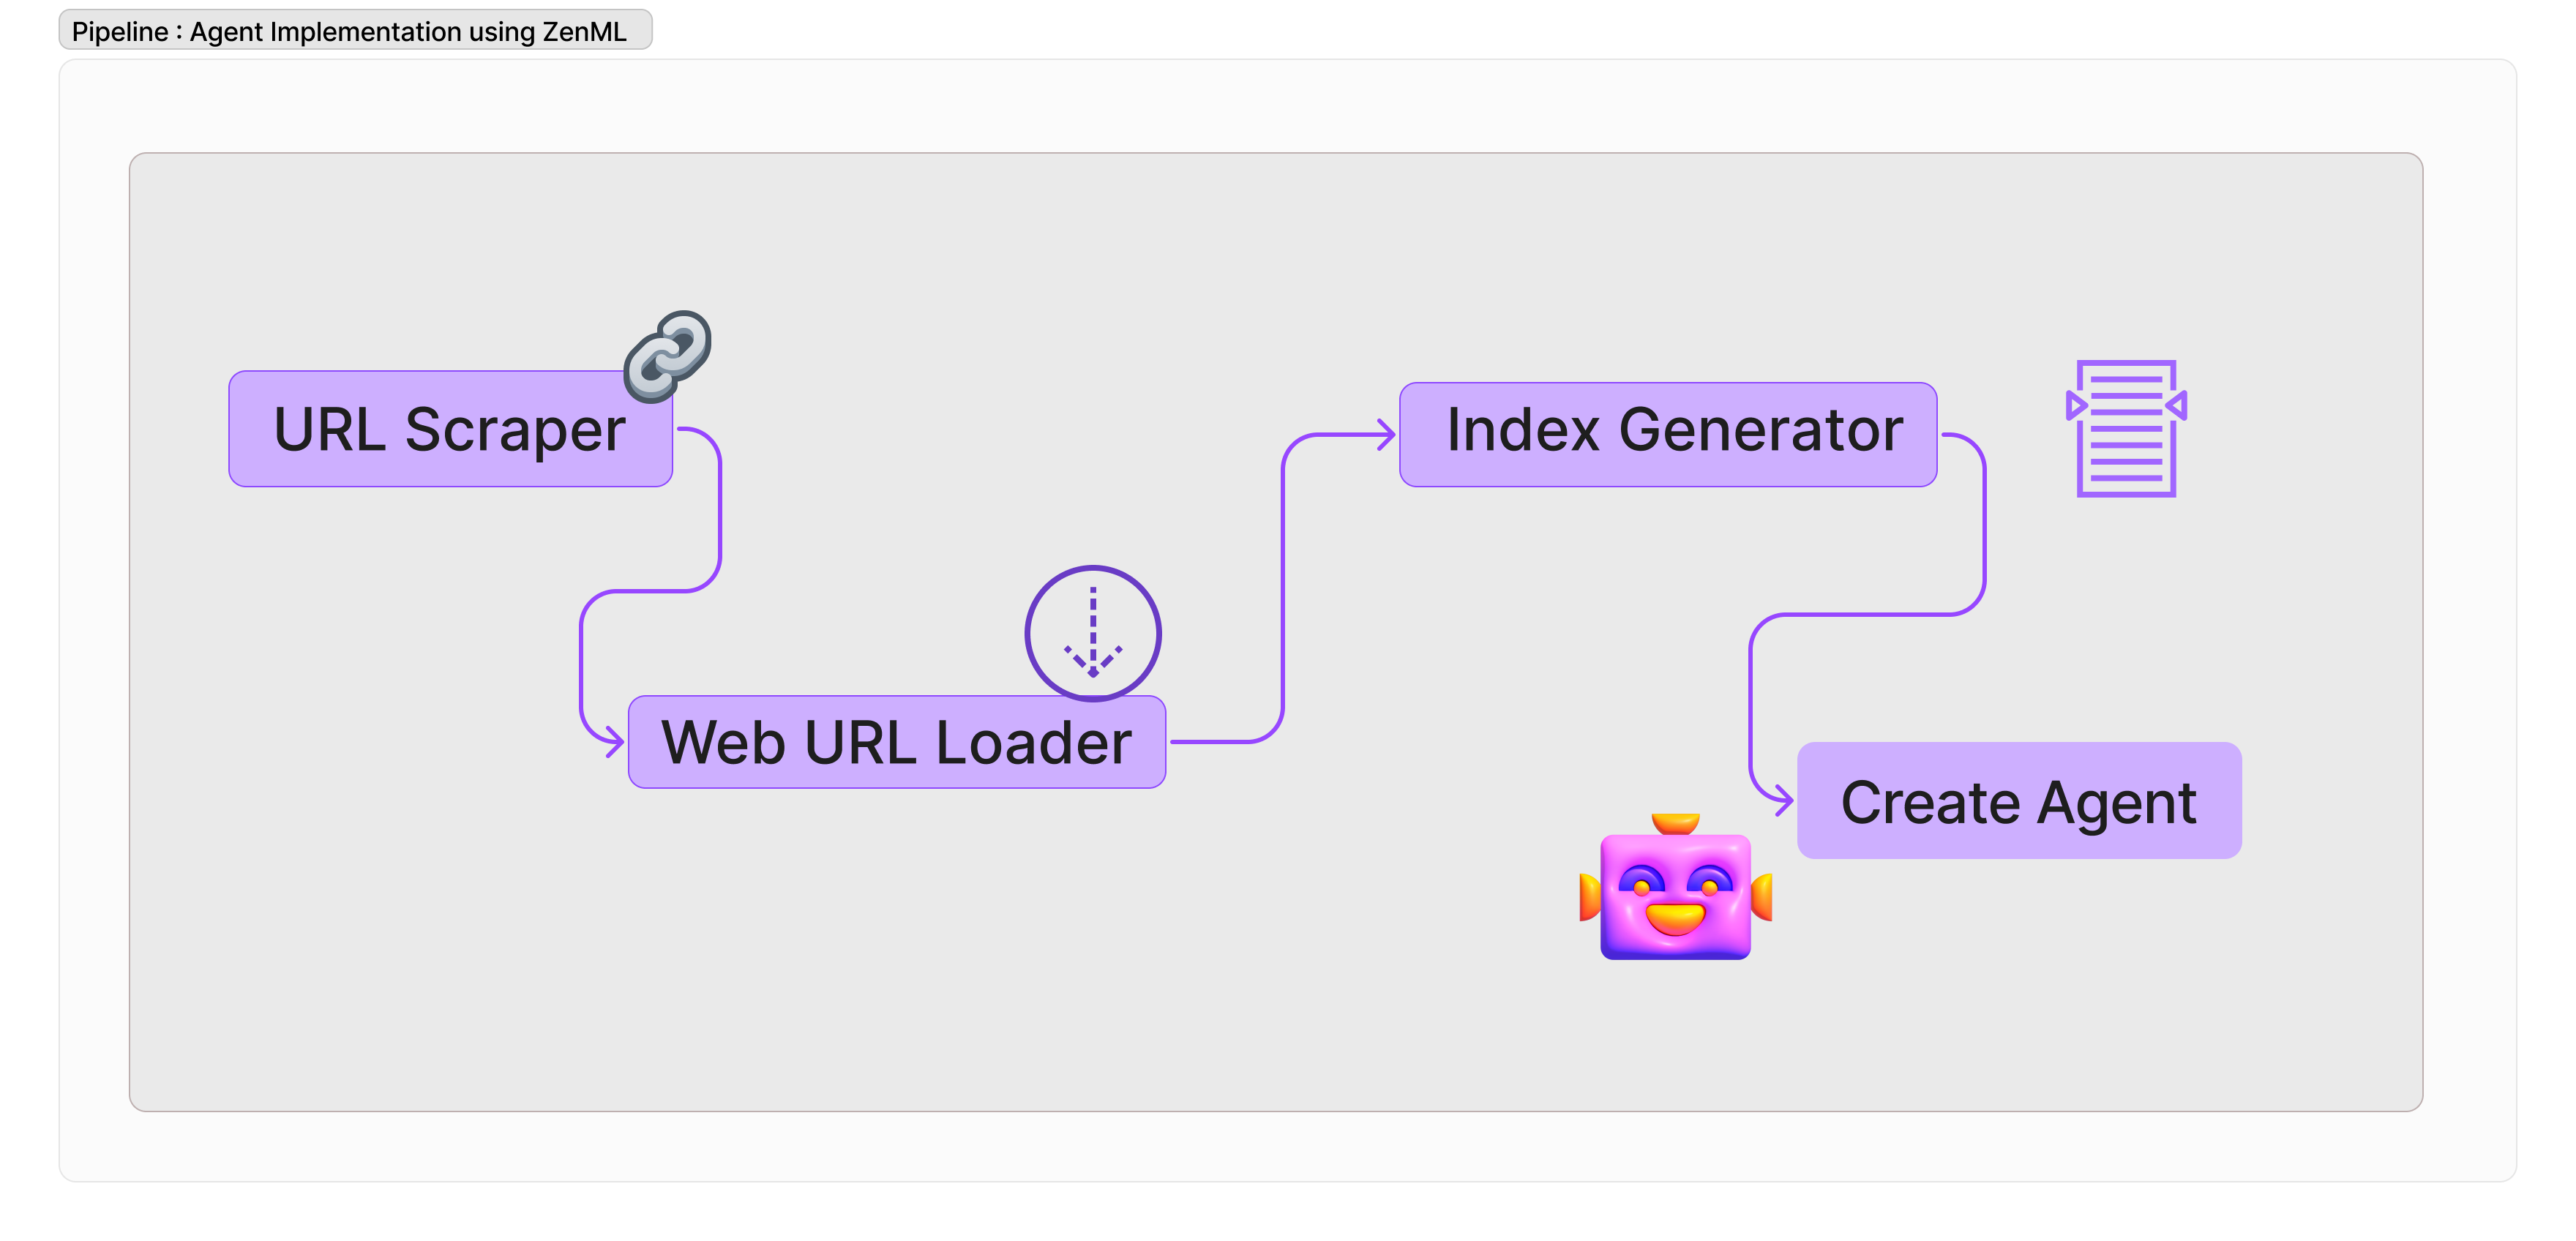

Our pipeline will consist of the following steps:

- **URL Scraper**: This step will scrape the URLs of the documentation that we pass through it. It will return a list of URLs to load.

- **Web URL Loader**: This step will load the HTML content of the URLs passed through it. It will return a list of Documents.

- **Index Generator**: This step will generate an index of the documents passed through it. It will return a vector store collection.

- **Agent Creator**: This step takes in the vector store and returns a LangChain AgentExecutor which we can run queries against.

### The URL Scraper

All that you need to do to convert a simple python function into a ZenML step is add the `@step` decorator.
Adding this decorator tells ZenML to
- allow this function to be passed in as a pipeline step.
- track and version the outputs of this step in your active artifact store (configured by the ZenML Stack).
- allow additional options like enabling cache, setting remote execution environments for the step and more!

In [1]:
from typing import List

from steps.url_scraping_utils import get_all_pages, get_nested_readme_urls
from zenml import step


@step(enable_cache=True)
def url_scraper(
    docs_url: str = "",
    repo_url: str = "",
    release_notes_url: str = "",
    website_url: str = "",
) -> List[str]:
    """Generates a list of relevant URLs to scrape.

    Args:
        docs_url: URL to the documentation.
        repo_url: URL to the repository.
        release_notes_url: URL to the release notes.
        website_url: URL to the website.

    Returns:
        List of URLs to scrape.
    """
    # examples_readme_urls = get_nested_readme_urls(repo_url)
    docs_urls = get_all_pages(docs_url)
    website_urls = get_all_pages(website_url)
    return docs_urls + website_urls + [release_notes_url]

Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


### The Web URL Loader

This step makes use of the UnstructuredURLLoader wrapper from LangChain to load the URLs as documents.

You can import any libraries that you would want to use and use it inside a step definition. Running it locally only requires that you have the library installed on your environment. When you want to run on a remote stack, you can either choose to allow ZenML to derive dependencies from your local envrionment, or pass in the requirements explicitly (more on this later).

In [2]:
from langchain.docstore.document import Document
from langchain.document_loaders import UnstructuredURLLoader


@step(enable_cache=True)
def web_url_loader(urls: List[str]) -> List[Document]:
    """Loads documents from a list of URLs.

    Args:
        urls: List of URLs to load documents from.

    Returns:
        List of langchain documents.
    """
    loader = UnstructuredURLLoader(
        urls=urls,
    )
    return loader.load()

### The Index Generator

Here, we use FAISS as our vector store of choice, along with OpenAI embeddings to generate a collection from the documents passed from the previous step.

You can also choose some other store as you wish; the step implementation will change but the rest of the pipeline will stay the same. You can also choose to create a new function and then pass that to the pipeline instead of the one we have here. This way, ZenML allows you to easily switch between implementations without trouble.

In [3]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import (
    CharacterTextSplitter,
)
from langchain.vectorstores import FAISS, VectorStore


@step(enable_cache=True)
def index_generator(documents: List[Document]) -> VectorStore:
    embeddings = OpenAIEmbeddings()

    text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
    compiled_texts = text_splitter.split_documents(documents)

    return FAISS.from_documents(compiled_texts, embeddings)

### The Agent Creator

With the agent creator, we define:
- a VectorStoreQATool from LangChain's set of available tools, with the vector store we created in the previous step.
- a LangChain agent with some custom prompts. This is done to customize the personality of the agent and make it identify as a ZenML bot. You can also play around with the prompt to change how the agent talks (think pirate, shakespeare, etc.).
- a LangChain AgentExecutor which we can use to run queries against the agent. This AgentExecutor acts like a middleman facilitating communication between the LLM and the tools.

#### Custom Materializer

You may notice that we have specified an `output_materializer` in the step decorator. A materializer in ZenML is what defines how an object is serialized and deserialized while moving between steps. ZenML comes with a host of built-in materializers that include basic types, collections and pydantic objects, along with a default cloudpickle materializer. 

You can also define your own custom materializers. Here, we are using a custom materializer (defined in the agent/ directory) for the AgentExecutor type, which is a pydantic object that doesn't have a `.json()` implementation. 
Instead of passing it in the decorator, you can also simply specify the data type a materializer can handle while defining it and ZenML will pick it up automatically and match any relevant output types to it.

In [5]:
import logging
from typing import Dict, cast

from agent.agent_executor_materializer import AgentExecutorMaterializer
from agent.prompt import PREFIX, SUFFIX
from langchain.agents import ConversationalChatAgent
from langchain.chat_models import ChatOpenAI
from langchain.vectorstores import VectorStore
from langchain.tools.vectorstore.tool import VectorStoreQATool
from langchain.agents import AgentExecutor
from steps.agent_creator import AgentParameters
from zenml import step


PIPELINE_NAME = "zenml_agent_creation_pipeline"


@step(output_materializers=AgentExecutorMaterializer, enable_cache=False)
def agent_creator(
    vector_store: VectorStore, config: AgentParameters
) -> AgentExecutor:
    """Create an agent from a vector store.

    Args:
        vector_store: Vector store to create agent from.

    Returns:
        An AgentExecutor.
    """
    tools = [
        VectorStoreQATool(
            name=f"zenml",
            vectorstore=vector_store,
            description="Use this tool to answer questions about ZenML. "
            "How to debug errors in ZenML, how to answer conceptual "
            "questions about ZenML like available features, existing abstractions, "
            "and other parts from the documentation.",
            llm=ChatOpenAI(**config.llm),
        ),
    ]

    my_agent = ConversationalChatAgent.from_llm_and_tools(
        llm=ChatOpenAI(**config.llm),
        tools=tools,
        system_message=PREFIX,
        human_message=SUFFIX,
    )

    agent_executor = AgentExecutor.from_agent_and_tools(
        agent=my_agent,
        tools=tools,
        verbose=True,
    )

    logging.info("About to return agent executor.")
    return agent_executor


### Creating a ZenML pipeline

A pipeline is where you chain all the steps together. The order of execution is determined by the relationship between outputs and inputs across steps. You can also choose to add explicit dependencies using `.after()` and `.before()`.

The output of each step is tracked and versioned in the artifact store that you configure in your ZenML stack (local, by deafult). ZenML does the heavy-lifting of making sure that the right data is available to the step that needs it.

In [6]:
from zenml import pipeline


@pipeline(name=PIPELINE_NAME, enable_cache=True)
def docs_to_agent_pipeline(
    docs_url: str = "",
    repo_url: str = "",
    release_notes_url: str = "",
    website_url: str = "",
) -> None:
    """Generate index for ZenML.

    Args:
        docs_url: URL to the documentation.
        repo_url: URL to the repository.
        release_notes_url: URL to the release notes.
        website_url: URL to the website.
    """
    urls = url_scraper(docs_url, repo_url, release_notes_url, website_url)
    documents = web_url_loader(urls)
    vector_store = index_generator(documents)
    agent = agent_creator(vector_store=vector_store)


### 🚀 Running the pipeline with the ZenML Docs and website data.

In [ ]:
version = "0.44.1"
docs_url = f"https://docs.zenml.io/v/{version}/"
website_url = "https://zenml.io"
repo_url = f"https://github.com/zenml-io/zenml/tree/{version}/examples"
release_notes_url = (
    f"https://github.com/zenml-io/zenml/blob/{version}/RELEASE_NOTES.md"
)

docs_to_agent_pipeline(
    website_url=website_url,
    docs_url=docs_url,
    repo_url=repo_url,
    release_notes_url=release_notes_url,
)